In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import JasperRidge
from HySpecLab.metrics import rmse

In [2]:
dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
wv = np.array(dataset.wv, dtype=np.uint)

result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')

# Ground Truth

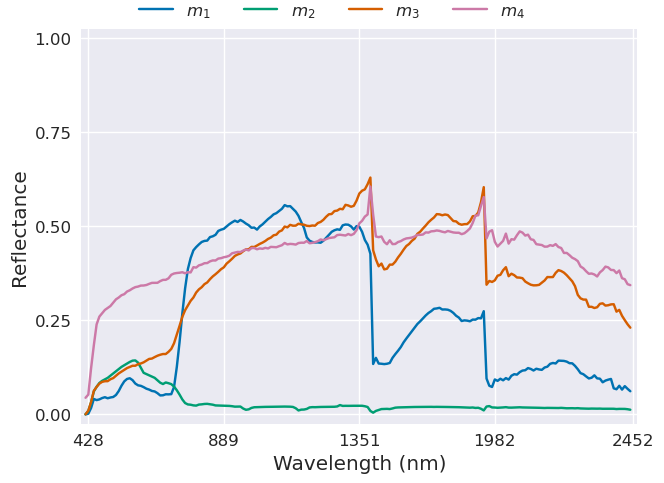

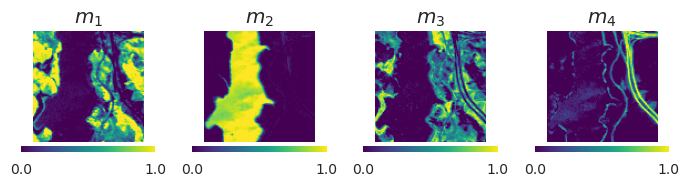

In [3]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), wv, ticks_range=(0, 1), n_ticks=5)
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [4]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

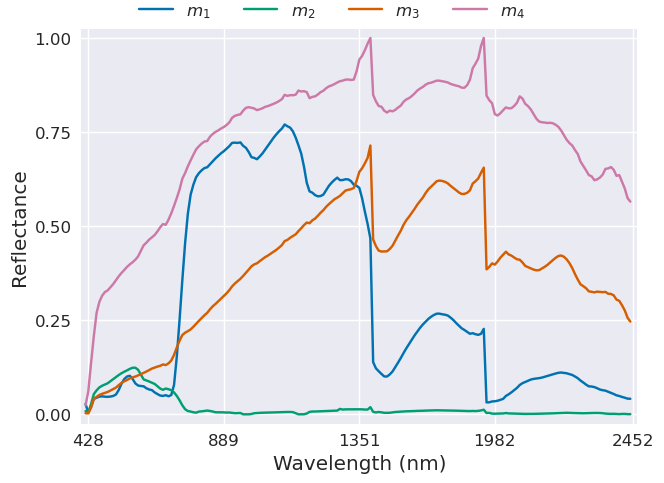

In [5]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=-1, random_state=25)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

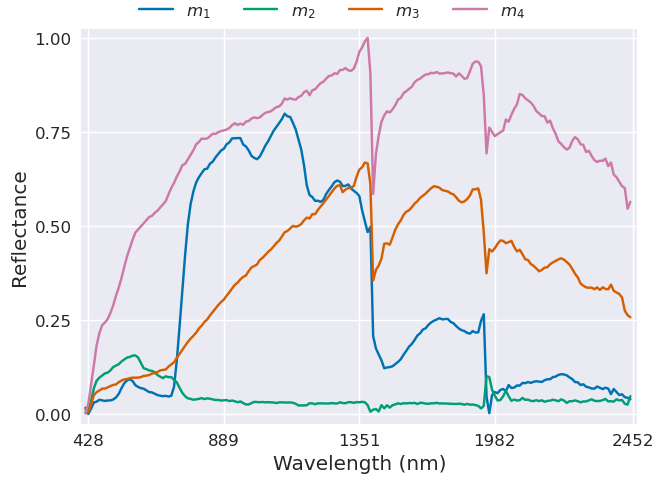

In [6]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

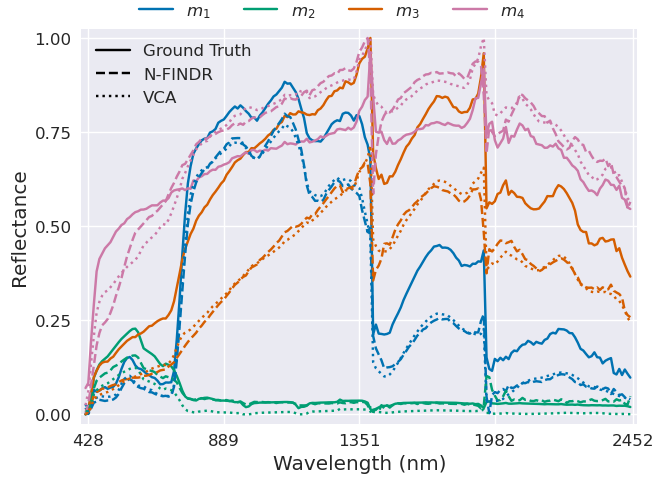

In [7]:
fig = plot_endmembers(dataset.endmembers() / dataset.endmembers().max(), wv, ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [8]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [497]:
import numpy as np
import torch

from torch.nn import Parameter
from torch.nn import functional as F

    
class GaussianSparseness(nn.Linear):
    def __init__(self, in_features: int, sigma:float=.5) -> None:
        super(GaussianSparseness, self).__init__(in_features, 1, True)
        self.sigma = sigma
        self.__mu = None
        self.bias.data.fill_(0)

    def forward(self, x):
        self.__mu = F.sigmoid(F.linear(x, self.weight, self.bias)) 
        eps = torch.normal(0, torch.ones_like(self.__mu))
        prob = self.__mu + (self.sigma * eps * self.training)
        return F.hardtanh(prob, 0, 1)
    
    def regularize(self):
        r'''
            The expected regularization is the sum of the probabilities 
            that the gates are active
        '''
        # return torch.mean(self._guassian_cdf(1-self.__mu, self.sigma))
        return torch.mean(self._guassian_cdf(self.__mu, self.sigma))
        
    def _guassian_cdf(self, mu:torch.Tensor, sigma:float) -> torch.Tensor:
        r''' 
            Guassian CDF
            
            Based on: https://stackoverflow.com/questions/809362/how-to-calculate-cumulative-normal-distribution

            Parameters
            ----------
            mu: torch.Tensor, shape (in_features,)
                The mean of the Guassian
            
            sigma: float
                The standard deviation of the Guassian
        '''
        return .5 * (1 + torch.erf(mu / (sigma*np.sqrt(2))))
    
    def variational_parameter(self):
        return self.__mu
    
    def __repr__(self):
        return f'GaussianSparseness(in_features={self.in_features}, sigma={self.sigma:.2f})'

In [498]:
import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from collections import deque
from itertools import islice

def lmm(A: torch.Tensor, E: torch.Tensor) -> torch.Tensor:
    '''
        Linear Mixing Model, linear combination of endmembers.

        Args:
        -----
            A: Tensor, shape (bs, n_endmembers)
                Abundance matrix of the linear mixing model.
            E: Tensor, shape (n_endmembers, n_bands)
                Endmembers.
    '''
    bs, _ = A.shape
    return torch.bmm(A.unsqueeze(1), E.unsqueeze(0).expand(bs, -1, -1)).squeeze()

## General
def slide(iterable, size):
    '''
        Iterate through iterable using a sliding window of several elements.
        Important: It is a generator!.
        
        Creates an iterable where each element is a tuple of `size`
        consecutive elements from `iterable`, advancing by 1 element each
        time. For example:
        >>> list(sliding_window_iter([1, 2, 3, 4], 2))
        [(1, 2), (2, 3), (3, 4)]
        
        source: https://codereview.stackexchange.com/questions/239352/sliding-window-iteration-in-python
    '''
    iterable = iter(iterable)
    window = deque(islice(iterable, size), maxlen=size)
    for item in iterable:
        yield tuple(window)
        window.append(item)
    if window:  
        # needed because if iterable was already empty before the `for`,
        # then the window would be yielded twice.
        yield tuple(window)

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None, sparsity=.5) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        self.n_endmembers = n_endmembers
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        self.sparse_gate = GaussianSparseness(encode_layers[-1], sigma=sparsity)
        
        # Projection layer
        self.projection = nn.Linear(encode_layers[-1], n_bands, bias=False)

        self.A = None

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        z = self.encoder(input)
        r0 = self.projection(z)
        sparse = self.sparse_gate(z)

        self.A = self.__similarity(r0, sparse)
        return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor, sparse:torch.Tensor) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.         
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        v = (cos*.5) + .5
        eps = 1e-12
        return (1 + eps)/(sparse + eps)*torch.log(v/ (1-v))

        # return torch.exp(self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        # return torch.pow(self.n_endmembers, self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        # return self.sparse*torch.exp(v)*torch.log(v/ (1-v))
    
    

In [499]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from tqdm import tqdm
import torch

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, similarity_weight=1, sparse_weight=1e-1):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    for _ in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + similarity_weight*similarity_reg(model.ebk) +  sparse_weight*model.sparse_gate.regularize()
            # loss = criterion(y, x) + similarity_weight*similarity_reg(model.ebk) #+ sparse_weight/torch.abs(torch.exp(model._sparse)).mean()
            epoch_loss += loss.detach().item()

            loss.backward()
            optimizer.step()

        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

# Training

In [560]:
# from utils import train 
# from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
# model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=0)

model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sparsity=.25)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, sparse_weight=.5)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:08<00:00,  6.00epoch/s, tls=0.4914]


In [561]:
model.eval()
print(model.sparse_gate.variational_parameter().flatten())
print(model.sparse_gate.variational_parameter().flatten().mean())
print(model.sparse_gate.variational_parameter().flatten().min())
# print(model.sparse_gate(model.sparse))
# model.sparse_gate.mu.data = torch.tensor(1.)
# print(model.sparse_gate.mu)
# print(model.sparse_gate.regularize())

tensor([9.8924e-01, 9.9121e-01, 9.9762e-01, 2.2193e-04, 9.9789e-01, 9.7071e-01,
        9.9659e-01, 9.9975e-01, 9.9696e-01, 1.0186e-04, 9.8360e-01, 9.9765e-01,
        9.9965e-01, 9.9985e-01, 9.7853e-01, 6.7497e-05, 6.9545e-03, 1.4287e-06,
        9.9272e-01, 5.5849e-05, 7.5869e-03, 9.9981e-01, 2.5476e-05, 8.4881e-04,
        9.9900e-01, 9.9418e-01, 9.9375e-01, 9.9585e-01, 9.9951e-01, 1.3510e-05,
        9.9690e-01, 9.9682e-01, 9.9778e-01, 4.0172e-06, 9.9634e-01, 9.7566e-01,
        9.9622e-01, 9.3120e-01, 9.9964e-01, 6.7398e-05, 9.9996e-01, 9.9524e-01,
        9.9913e-01, 9.9502e-01, 9.9827e-01, 9.9786e-01, 9.9751e-01, 9.9544e-01,
        9.9698e-01, 7.0181e-04, 1.0926e-05, 9.9701e-01, 9.9818e-01, 9.9910e-01,
        9.9662e-01, 9.9429e-01, 5.5499e-07, 6.3707e-08, 9.9921e-01, 5.2868e-04,
        9.9899e-01, 9.9634e-01, 9.8166e-01, 9.9315e-01, 9.7824e-05, 2.5700e-06,
        9.7361e-01, 3.0812e-02, 9.9901e-01, 4.9940e-04, 9.9813e-01, 1.1276e-02,
        9.9931e-01, 3.8850e-04, 9.9375e-

# Save model

In [562]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing model

In [563]:
# from HySpecLab.unmixing import ContrastiveUnmixing

# # load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [564]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=dataset.n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], dataset.n_endmembers)
similarity_reg = SimilarityLoss(dataset.n_endmembers, temperature=.1, reduction='mean')

In [565]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(model.ebk).cpu(),
         similarity_reg(model.ebk).cpu())

tensor(0.0377) tensor(0.5151) tensor(18992572.) tensor(0.0035)


In [566]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(203.2039), tensor(0.0168))

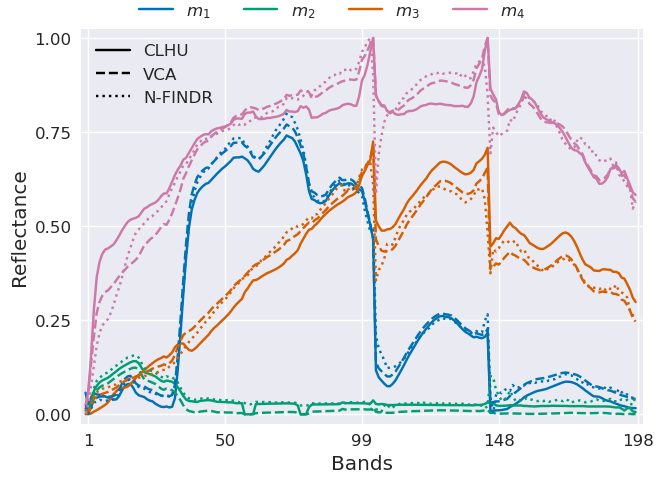

In [567]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init, nfindr_endmember_init], ee_labels=['CLHU',label, 'N-FINDR'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu.pdf'), bbox_inches='tight')

# fig = plot_endmembers(ebk, ticks_range=(0, 1))
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_2.pdf'), bbox_inches='tight')

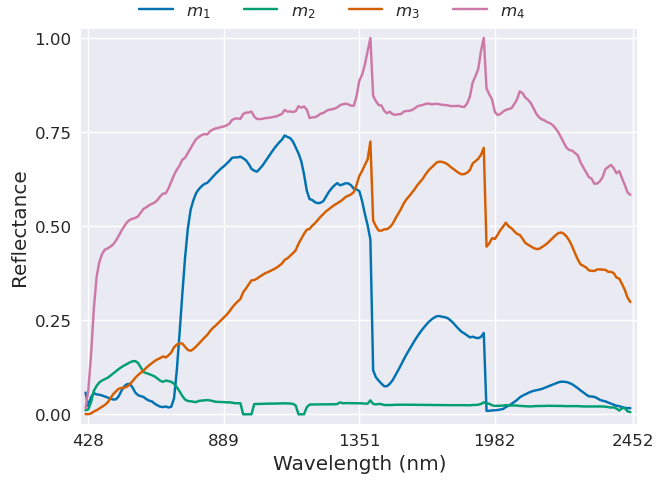

In [568]:
# fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
fig = plot_endmembers(ebk, wv=np.array(dataset.wv), ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_estimation_random.pdf'), bbox_inches='tight')

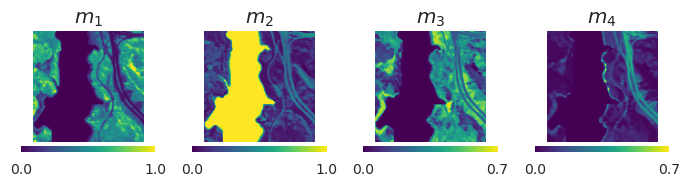

In [569]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

from matplotlib import pyplot as plt

def show_abundance(A, transpose=True, labels:list = None, figsize:tuple=(7,5)):
    '''
        Show abundance maps.

        Parameters
        ----------
            A : 3-D array, shape (n_rows, n_cols, n_endmembers)
                Abundance maps.
            labels : list, optional
                Labels for endmembers. Default is None.
            figsize : tuple, optional
                Figure size. Default is (7,5).
    '''
    _, _, n_endmembers = A.shape

    if labels is None:
        labels = list(map(lambda x: r'$m_{{{}}}$'.format(x), range(1, n_endmembers+1)))
        
    ticks_formatter = plt.FormatStrFormatter('%.1f')
    fig = plt.figure(figsize=(7,5))
    for i in range(n_endmembers):
        data = A[:,:,i].T if transpose else A[:,:,i]
        plt.subplot(3,4,i+1)
        plt.imshow(data, cmap='viridis')
        plt.axis('off')
        plt.title(labels[i], fontsize='x-large')
        cb = plt.colorbar(format=ticks_formatter, ticks=[data.min() + 1e-3, data.max() - 1e-3],
                         orientation='horizontal', fraction=0.1, pad=0.03)

    plt.tight_layout()
    return fig

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/imgs/A_estimation_random.png'), dpi=300, bbox_inches='tight')

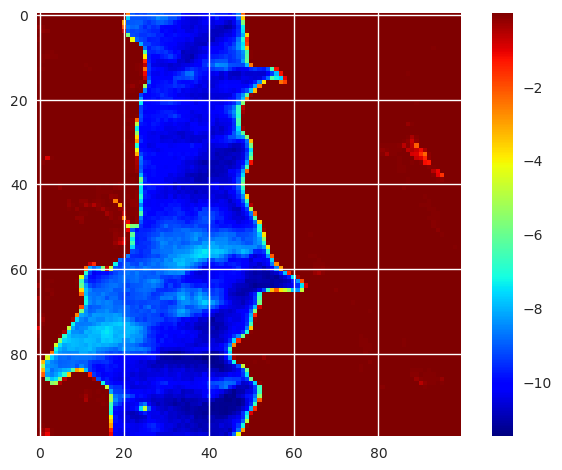

In [570]:
# test = model._sparse.detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
test = model.sparse_gate.variational_parameter().detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
test = np.log(test)
plt.imshow(test.T, cmap='jet')
plt.colorbar()
plt.show()

In [571]:
X_true = dataset.A @ dataset.endmembers()
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

real_M_hat = model(M_hat).detach()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

sad_result = sad(M_hat, dataset.endmembers()).numpy()
# sad_result = sad(real_M_hat, dataset.endmembers()).numpy()
df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/M_random_metrics.csv'), index=False)
print(np.diagonal(sad(real_M_hat, dataset.endmembers()).numpy()).mean())
df

0.11463803


,Method,RMSE_X,RMSE_A,SAD_M
0,CLHU,0.045420155,0.1638553,0.14108


tensor(9.9048e-14, grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


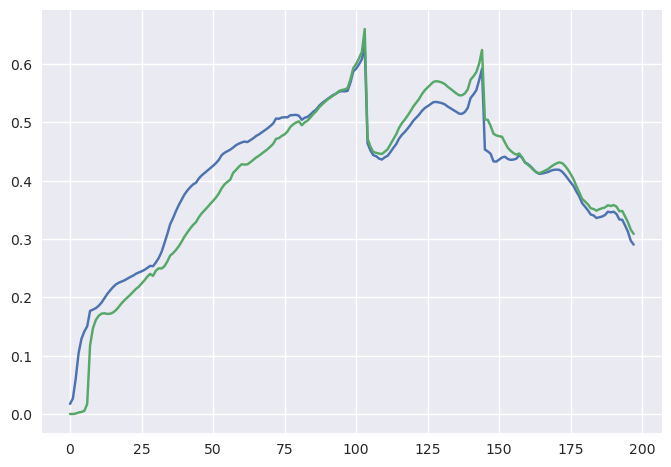

/tmp/ipykernel_23736/2033548742.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(model.A)


tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.1345, 0.1415, 0.4802, 0.2439],
        [0.0817, 0.0534, 0.3510, 0.5139]], grad_fn=<SoftmaxBackward0>)

In [496]:
# model.ebk = sigmoid(model.ebk)
x_test = sigmoid(model.ebk)
m = model.ebk.detach()
model.eval()
print(x_test.min(), x_test.max())
encoder, projection = model.encoder, model.projection
from torch.nn.functional import normalize, softmax

def __similarity(X: torch.Tensor, ebk, temperature=1e-2) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        # return (1 - torch.pow(cos, 2))/temperature
        # return (torch.pow(cos, 2))/temperature
        return torch.log(torch.pow(cos, 2))

# y = projection(encoder(x_test))
# print(softmax(__similarity(y, m, temperature=.1).detach(), dim=1))

test = model(x_test)

plt.plot(test[2].detach().numpy())
plt.plot(x_test[2].detach().numpy())
plt.show()

softmax(model.A)

# ...

In [ ]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [ ]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

In [ ]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

In [ ]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)

In [ ]:
os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method))

In [ ]:
plt.plot(sigmoid(model.ebk).T.detach().cpu().numpy())
plt.show()

In [ ]:
plt.plot(test.T.detach().cpu().numpy())
plt.show()

sad_m = np.diagonal(sad(test, dataset.endmembers()).detach().numpy()).mean()
sad_m

In [ ]:
from torch.nn.functional import normalize   
M = logit_endmember_init
M_norm = normalize(M, dim=1)

sim_matrix = torch.mm(M_norm, M_norm.T) / .1

logit = torch.log((sim_matrix).softmax(dim=1))
lo2 = (sim_matrix).log_softmax(dim=1)

sim_matrix, torch.isclose(logit, lo2)


In [ ]:
M_2 = M.clone()

M_2[0] = M_2[2]
M_norm = normalize(M_2, dim=1)

sim_matrix = torch.mm(M_norm, M_norm.T) / .1

logit = torch.log((sim_matrix).softmax(dim=1))
lo2 = (sim_matrix).log_softmax(dim=1)

sim_matrix, torch.isclose(logit, lo2)

# (sim_matrix).softmax(dim=1)

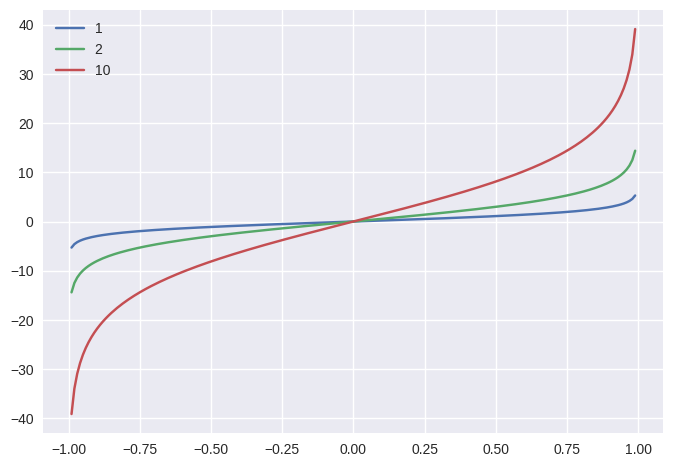

In [214]:
import torch
import matplotlib.pyplot as plt
cos = torch.arange(-1, 1, .01)
v = (cos*.5) + .5
data = torch.log(v/ (1-v))
data_1 = np.exp(1)*torch.log(v/ (1-v))
data_2 = np.exp(2)*torch.log(v/ (1-v))

plt.plot(cos, data, label='1')
plt.plot(cos, data_1, label='2')
plt.plot(cos, data_2, label='10')
plt.legend()
plt.show()

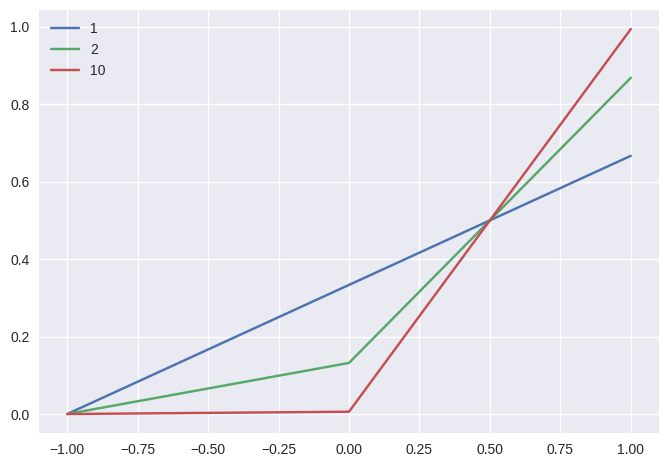

In [215]:
n = 3
# get the N cosine values in a linear space
cos_value = torch.linspace(-1, 1, n)
data = torch.log((cos_value*.5) + .5)
data_1 = np.exp(1)*torch.log((cos_value*.5) + .5)
data_2 = np.exp(2)*torch.log((cos_value*.5) + .5)
plt.plot(cos_value, torch.softmax(data, dim=0), label='1')
plt.plot(cos_value, torch.softmax(data_1, dim=0), label='2')
plt.plot(cos_value, torch.softmax(data_2, dim=0), label='10')
plt.legend()
plt.show()

In [209]:
np.exp(3)

20.085536923187668